<a href="https://colab.research.google.com/github/atimonin-ipynb/diploma_bachelor/blob/main/diploma_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation
from scipy.stats import norm

# Чтение, форматирование данных

In [ ]:
data = pd.read_excel('Minnibaevo_Kazan_diploma.xlsx')

In [ ]:
# Обрабатываем пропущенные значения (замена NaN на "Неизвестно" для категорий и медиану для числовых)
for col in data.columns:
    if data[col].dtype == 'object':
        data.loc[:, col] = data[col].fillna("Неизвестно")  # Используем явное присваивание
    else:
        data.loc[:, col] = data[col].fillna(data[col].median())

In [ ]:
data['Промежуток между исследованиями, лет'] = data['Год проведения шурфовки'] - data['Год проведения ВТД']
data['ВТД Дистанция по одометру от КЗ, км'] = data['ВТД Дистанция по одометру от КЗ, м'] // 1000
data['ВТД Дистанция по одометру, км'] = data['Км начала участка'] + data['ВТД Дистанция по одометру от КЗ, км']
data['Плотность дефектов на исследование'] = data['Кол-во обнаруженных дефектов Всего'] / data.groupby(['Участок', 'Год проведения ВТД'])['Кол-во обнаруженных дефектов Всего'].transform('count')
data['Плотность дефектов на км'] = data['Кол-во обнаруженных дефектов Всего'] / data['Протяженность участка, км']

In [ ]:
data = data.drop(columns = ['ВТД Дистанция по одометру от КЗ, км', 'Кол-во обнаруженных дефектов Всего'])

# Очистка данных

In [ ]:
data_clean = data[data['ВТД Тип дефекта'].isin(['Зона коррозии', 'Коррозия'])].copy()

In [ ]:
count_by_distance_before_clean = data_clean.groupby(['ВТД Дистанция по одометру, км']).size()

In [ ]:
color_metric = ['#D95F0E', '#F7E12B', '#3FA44A']
color_plot = ['#696969', '#8B0000']

In [ ]:
mask_depth = (data_clean['ВТД Глубина, мм'] > 0) & (data_clean['ВТД Глубина, мм'] < 12) & (data_clean['Шурфование Глубина, мм'] > 0) & (data_clean['Шурфование Глубина, мм'] < 12)
mask_length = (data_clean['ВТД Длина, мм'] > 0) & (data_clean['Шурфование Длина, мм'] > 0)
mask_width = (data_clean['ВТД Ширина, мм'] > 0) & (data_clean['ВТД Ширина, мм'] < 1020.5) & (data_clean['Шурфование Ширина, мм'] > 0) & (data_clean['Шурфование Ширина, мм'] < 1020.5)

data_clean = data_clean[mask_depth & mask_length & mask_width]

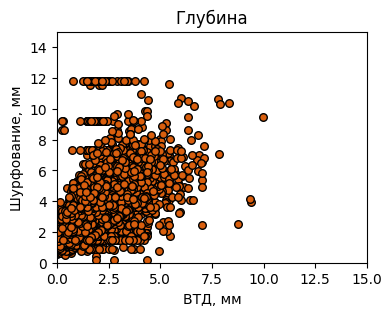

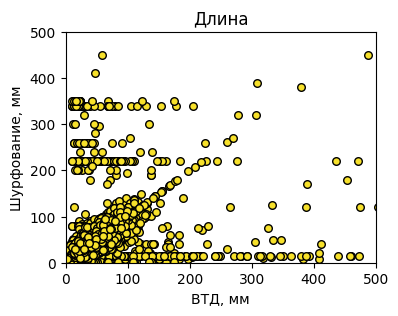

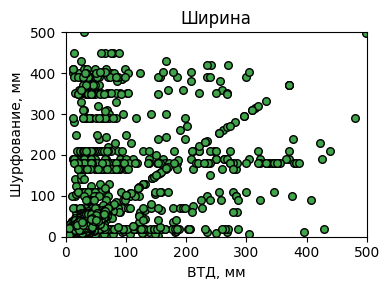

In [ ]:

# Первый подграфик
plt.figure(figsize=(4, 3))
plt.scatter(data_clean['ВТД Глубина, мм'], data_clean['Шурфование Глубина, мм'],
            color=color_metric[0], alpha=1, s=30, edgecolor='black')
plt.title('Глубина')
plt.xlabel('ВТД, мм')
plt.ylabel('Шурфование, мм')
plt.xlim(0,15)
plt.ylim(0,15)

# Второй подграфик
# plt.subplot(312)
plt.figure(figsize=(4, 3))
plt.scatter(data_clean['ВТД Длина, мм'], data_clean['Шурфование Длина, мм'],
            color=color_metric[1], alpha=1, s=30, edgecolor='black')
plt.title('Длина')
plt.xlabel('ВТД, мм')
plt.ylabel('Шурфование, мм')
plt.xlim(0,500)
plt.ylim(0,500)

# Третий подграфик
# plt.subplot(313)
plt.figure(figsize=(4, 3))
plt.scatter(data_clean['ВТД Ширина, мм'], data_clean['Шурфование Ширина, мм'],
            color=color_metric[2], alpha=1, s=30, edgecolor='black')
plt.title('Ширина')
plt.xlabel('ВТД, мм')
plt.ylabel('Шурфование, мм')
plt.xlim(0,500)
plt.ylim(0,500)

plt.tight_layout()
plt.show()


In [ ]:
# Функция для вычисления относительного расхождения
def calculate_relative_difference(vtd, shurf):
    if shurf == 0:
        return None  # Исключаем строки с нулевыми значениями шурфовки
    return abs(vtd - shurf) / shurf * 100

# Вычисление относительного расхождения для глубины, длины и ширины
data_clean['Глубина расхождение'] = data_clean.apply(lambda row: calculate_relative_difference(row['ВТД Глубина, мм'], row['Шурфование Глубина, мм']), axis=1)
data_clean['Длина расхождение'] = data_clean.apply(lambda row: calculate_relative_difference(row['ВТД Длина, мм'], row['Шурфование Длина, мм']), axis=1)
data_clean['Ширина расхождение'] = data_clean.apply(lambda row: calculate_relative_difference(row['ВТД Ширина, мм'], row['Шурфование Ширина, мм']), axis=1)

# Теперь для каждого порога от 0 до 100 рассчитываем процент совпадений
thresholds = list(range(0, 101))  # Пороги от 0 до 100
depth_matching_percent = []
length_matching_percent = []
width_matching_percent = []

# Для каждого порога вычисляем процент совпадений
for threshold in thresholds:
    # Глубина
    depth_matching = data_clean[data_clean['Глубина расхождение'] <= threshold].shape[0]
    depth_matching_percent.append(depth_matching / data_clean.shape[0] * 100)

    # Длина
    length_matching = data_clean[data_clean['Длина расхождение'] <= threshold].shape[0]
    length_matching_percent.append(length_matching / data_clean.shape[0] * 100)

    # Ширина
    width_matching = data_clean[data_clean['Ширина расхождение'] <= threshold].shape[0]
    width_matching_percent.append(width_matching / data_clean.shape[0] * 100)


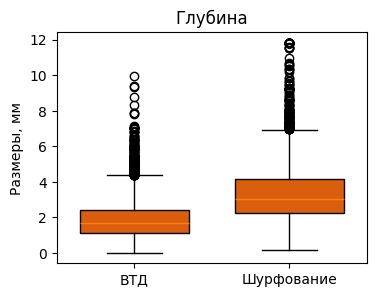

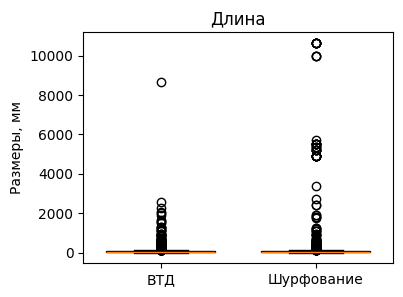

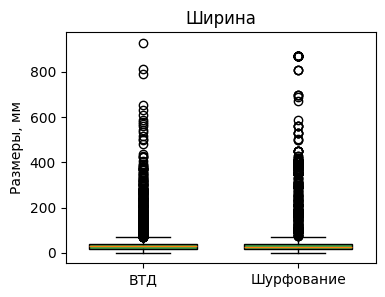

In [ ]:

# plt.figure(figsize=(12, 3))

labels = ['ВТД', 'Шурфование']  # Подписи для каждого боксплота

# plt.subplot(131)
plt.figure(figsize=(4, 3))
plt.boxplot(data_clean['ВТД Глубина, мм'], positions=[0], widths=0.7, patch_artist=True, boxprops=dict(facecolor=color_metric[0]))
plt.boxplot(data_clean['Шурфование Глубина, мм'], positions=[1], widths=0.7, patch_artist=True, boxprops=dict(facecolor=color_metric[0]))
plt.xticks([0, 1], labels)
plt.ylabel('Размеры, мм')
plt.title('Глубина')
# plt.grid()

# plt.subplot(132)
plt.figure(figsize=(4, 3))
plt.boxplot(data_clean['ВТД Длина, мм'], positions=[0], widths=0.7, patch_artist=True, boxprops=dict(facecolor=color_metric[1]))
plt.boxplot(data_clean['Шурфование Длина, мм'], positions=[1], widths=0.7, patch_artist=True, boxprops=dict(facecolor=color_metric[1]))
plt.xticks([0, 1], labels)
plt.ylabel('Размеры, мм')
plt.title('Длина')
# plt.grid()

# plt.subplot(133)
plt.figure(figsize=(4, 3))
plt.boxplot(data_clean['ВТД Ширина, мм'], positions=[0], widths=0.7, patch_artist=True, boxprops=dict(facecolor=color_metric[2]))
plt.boxplot(data_clean['Шурфование Ширина, мм'], positions=[1], widths=0.7, patch_artist=True, boxprops=dict(facecolor=color_metric[2]))
plt.xticks([0, 1], labels)
plt.ylabel('Размеры, мм')
plt.title('Ширина')
# plt.grid()

plt.show()


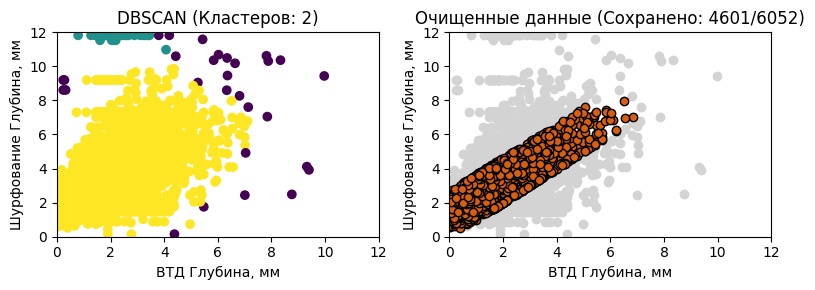

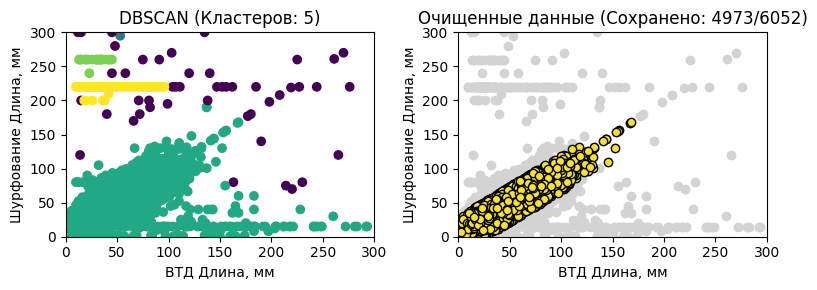

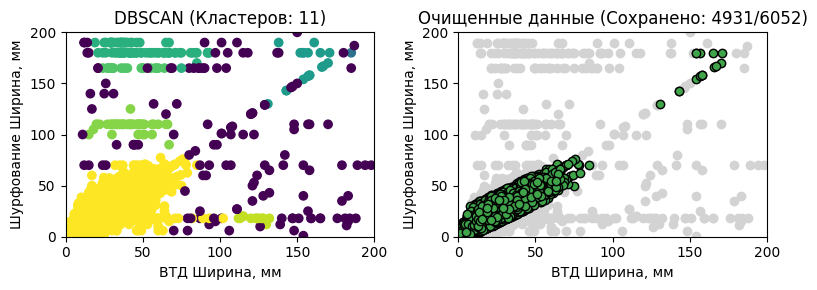

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.exceptions import UndefinedMetricWarning
import hdbscan
from math import atan, degrees
import warnings

# Фильтрация специфических предупреждений
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="hdbscan")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


def clean_data(df, col1, col2, alpha=15, max_distance=2, type_metric='Глубина'):
    metric_color = {'Глубина' : color_metric[0], 'Длина' : color_metric[1], 'Ширина' : color_metric[2]}
    metric_limit_plt = {'Глубина': (0, 12), 'Длина': (0, 300), 'Ширина': (0, 200)}

    # Шаг 0: Подготовка данных с RobustScaler
    X = df[[col1, col2]].dropna().values
    if len(X) == 0:
        return np.zeros(len(df), dtype=bool)

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Шаг 1: Кластеризация HDBSCAN с оптимизированными параметрами
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=10,
        cluster_selection_epsilon=0.5,
        metric='euclidean'
    )
    clusters = clusterer.fit_predict(X_scaled)

    # Визуализация
    plt.figure(figsize=(8, 3))
    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', alpha=1)
    plt.title(f'DBSCAN (Кластеров: {len(np.unique(clusters))-1})')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.xlim(*metric_limit_plt[type_metric])
    plt.ylim(*metric_limit_plt[type_metric])

    # Шаг 2: Фильтрация и RANSAC
    final_mask = np.zeros(len(df), dtype=bool)
    valid_indices = np.arange(len(X))

    for cluster_id in np.unique(clusters):
        if cluster_id == -1:
            continue

        cluster_mask = (clusters == cluster_id)
        X_cluster = X_scaled[cluster_mask]
        original_indices = valid_indices[cluster_mask]

        # Пропускаем маленькие кластеры
        if len(X_cluster) < 5:
            continue

        try:
            # RANSAC с обработкой исключений
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ransac = RANSACRegressor(
                    estimator=LinearRegression(),
                    residual_threshold=0.7,
                    min_samples=5
                ).fit(X_cluster[:, [0]], X_cluster[:, 1])

            # Расчет параметров
            k_scaled = ransac.estimator_.coef_[0]
            k_original = k_scaled * (scaler.scale_[1] / scaler.scale_[0])
            angle = degrees(atan(k_original)) % 180
            angle = angle - 180 if angle > 90 else angle

            # Проверка условий
            distances = np.abs(X_cluster[:,0] - X_cluster[:,1]) / np.sqrt(2)
            if (45 - alpha <= angle <= 45 + alpha) and (np.mean(distances) <= max_distance):
                final_mask[original_indices[ransac.inlier_mask_]] = True

        except Exception as e:
            continue

    # Визуализация результатов
    plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', alpha=1)
    plt.scatter(X[final_mask[:len(X)], 0], X[final_mask[:len(X)], 1],
                c=metric_color[type_metric], edgecolor='black')
    plt.title(f'Очищенные данные (Сохранено: {final_mask.sum()}/{len(X)})')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.xlim(*metric_limit_plt[type_metric])
    plt.ylim(*metric_limit_plt[type_metric])
    plt.tight_layout()
    plt.show()

    return final_mask

# Применение функции
mask = np.ones(len(data_clean), dtype=bool)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mask &= clean_data(data_clean, 'ВТД Глубина, мм', 'Шурфование Глубина, мм', type_metric='Глубина')
    mask &= clean_data(data_clean, 'ВТД Длина, мм', 'Шурфование Длина, мм', type_metric='Длина')
    mask &= clean_data(data_clean, 'ВТД Ширина, мм', 'Шурфование Ширина, мм', type_metric='Ширина')

In [ ]:
# Применяем маску для удаления выбросов

old_size = data_clean.shape[0]
data_clean = data_clean[mask]
new_size = data_clean.shape[0]
print(f'Размерность очищенной выборки {data_clean.shape[0]}, Процент удаленных аномалий {(1 - new_size/old_size)*100}')

Размерность очищенной выборки 3733, Процент удаленных аномалий 38.31791143423662


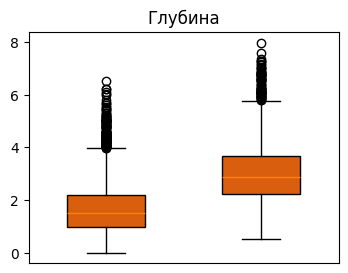

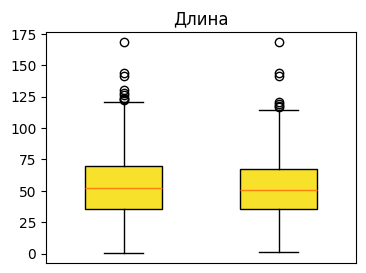

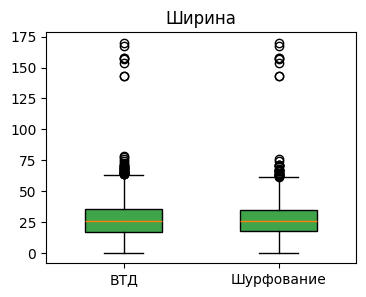

In [ ]:

# plt.figure(figsize=(15, 4))

labels = ['ВТД', 'Шурфование']  # Подписи для каждого боксплота

# plt.subplot(131)
plt.figure(figsize=(4, 3))
plt.boxplot(data_clean['ВТД Глубина, мм'], positions=[0], widths=0.5, patch_artist=True, boxprops=dict(facecolor=color_metric[0]))
plt.boxplot(data_clean['Шурфование Глубина, мм'], positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor=color_metric[0]))
plt.xticks([])
# plt.ylabel('Размеры')
plt.title('Глубина')
# plt.grid()

# plt.subplot(132)
plt.figure(figsize=(4, 3))
plt.boxplot(data_clean['ВТД Длина, мм'], positions=[0], widths=0.5, patch_artist=True, boxprops=dict(facecolor=color_metric[1]))
plt.boxplot(data_clean['Шурфование Длина, мм'], positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor=color_metric[1]))
plt.xticks([])
# plt.ylabel('Размеры')
plt.title('Длина')
# plt.grid()

# plt.subplot(133)
plt.figure(figsize=(4, 3))
plt.boxplot(data_clean['ВТД Ширина, мм'], positions=[0], widths=0.5, patch_artist=True, boxprops=dict(facecolor=color_metric[2]))
plt.boxplot(data_clean['Шурфование Ширина, мм'], positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor=color_metric[2]))
plt.xticks([0, 1], labels)
# plt.ylabel('Размеры')
plt.title('Ширина')
# plt.grid()

plt.show()


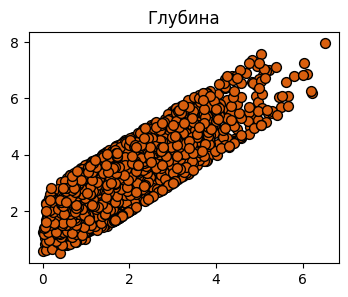

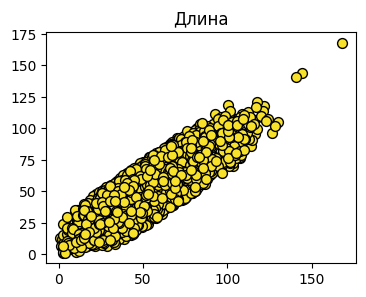

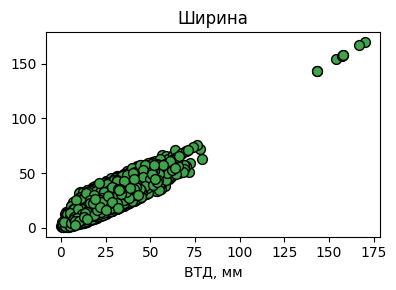

In [ ]:

# plt.figure(figsize=(8, 3))

# Первый подграфик
# plt.subplot(131)
plt.figure(figsize=(4, 3))
plt.scatter(data_clean['ВТД Глубина, мм'], data_clean['Шурфование Глубина, мм'],
            color=color_metric[0], alpha=1, s=50, edgecolor='black')
plt.title('Глубина')
# plt.xlabel('ВТД Глубина, мм')
# plt.ylabel('Шурфование, мм')

# Второй подграфик
# plt.subplot(132)
plt.figure(figsize=(4, 3))
plt.scatter(data_clean['ВТД Длина, мм'], data_clean['Шурфование Длина, мм'],
            color=color_metric[1], alpha=1, s=50, edgecolor='black')
plt.title('Длина')
# plt.xlabel('ВТД Длина, мм')
# plt.ylabel('Шурфование Длина, мм')

# Третий подграфик
# plt.subplot(133)
plt.figure(figsize=(4, 3))
plt.scatter(data_clean['ВТД Ширина, мм'], data_clean['Шурфование Ширина, мм'],
            color=color_metric[2], alpha=1, s=50, edgecolor='black')
plt.title('Ширина')
plt.xlabel('ВТД, мм')
# plt.ylabel('Шурфование, мм')

plt.tight_layout()
plt.show()


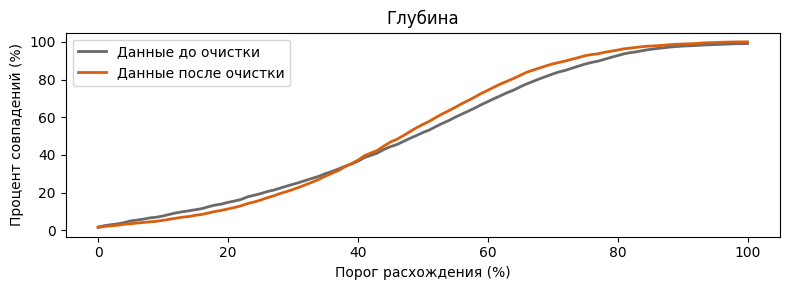

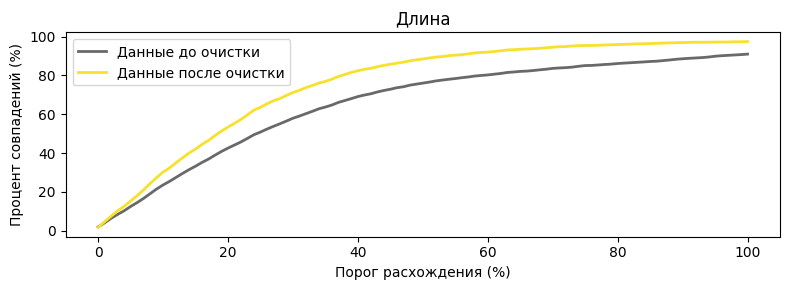

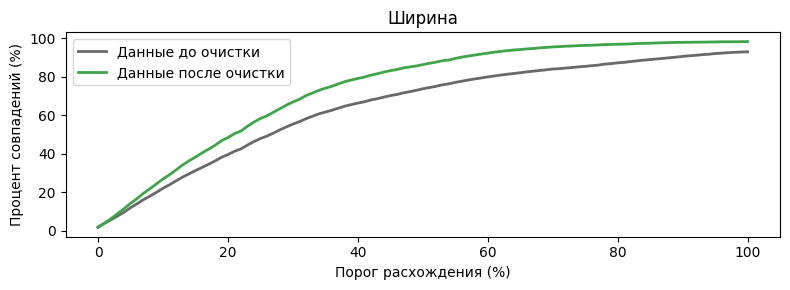

In [ ]:
# Функция для вычисления относительного расхождения
def calculate_relative_difference(vtd, shurf):
    if shurf == 0:
        return None  # Исключаем строки с нулевыми значениями шурфовки
    return abs(vtd - shurf) / shurf * 100

# Вычисление относительного расхождения для глубины, длины и ширины
data_clean['Глубина расхождение, очищенный'] = data_clean.apply(lambda row: calculate_relative_difference(row['ВТД Глубина, мм'], row['Шурфование Глубина, мм']), axis=1)
data_clean['Длина расхождение, очищенный'] = data_clean.apply(lambda row: calculate_relative_difference(row['ВТД Длина, мм'], row['Шурфование Длина, мм']), axis=1)
data_clean['Ширина расхождение, очищенный'] = data_clean.apply(lambda row: calculate_relative_difference(row['ВТД Ширина, мм'], row['Шурфование Ширина, мм']), axis=1)

# Теперь для каждого порога от 0 до 100 рассчитываем процент совпадений
thresholds = list(range(0, 101))  # Пороги от 0 до 100
depth_matching_percent_clean = []
length_matching_percent_clean = []
width_matching_percent_clean = []

# Для каждого порога вычисляем процент совпадений
for threshold in thresholds:
    # Глубина
    depth_matching = data_clean[data_clean['Глубина расхождение, очищенный'] <= threshold].shape[0]
    depth_matching_percent_clean.append(depth_matching / data_clean.shape[0] * 100)

    # Длина
    length_matching = data_clean[data_clean['Длина расхождение, очищенный'] <= threshold].shape[0]
    length_matching_percent_clean.append(length_matching / data_clean.shape[0] * 100)

    # Ширина
    width_matching = data_clean[data_clean['Ширина расхождение, очищенный'] <= threshold].shape[0]
    width_matching_percent_clean.append(width_matching / data_clean.shape[0] * 100)

# Построение графиков
# plt.figure(figsize=(8, 2))
# plt.subplot(131)
plt.figure(figsize=(8, 3))
plt.plot(thresholds, depth_matching_percent, label='Данные до очистки', color=color_plot[0], linewidth=2)
plt.plot(thresholds, depth_matching_percent_clean, label='Данные после очистки', color=color_metric[0], linewidth=2)
plt.title('Глубина')
plt.xlabel('Порог расхождения (%)')
plt.ylabel('Процент совпадений (%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()

# plt.subplot(132)
plt.figure(figsize=(8, 3))
plt.plot(thresholds, length_matching_percent, label='Данные до очистки', color=color_plot[0], linewidth=2)
plt.plot(thresholds, length_matching_percent_clean, label='Данные после очистки', color=color_metric[1], linewidth=2)
plt.title('Длина')
plt.xlabel('Порог расхождения (%)')
plt.ylabel('Процент совпадений (%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()

# plt.subplot(133)
plt.figure(figsize=(8, 3))
plt.plot(thresholds, width_matching_percent, label='Данные до очистки', color=color_plot[0], linewidth=2)
plt.plot(thresholds, width_matching_percent_clean, label='Данные после очистки', color=color_metric[2], linewidth=2)
plt.title('Ширина')
plt.xlabel('Порог расхождения (%)')
plt.ylabel('Процент совпадений (%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()

plt.show()

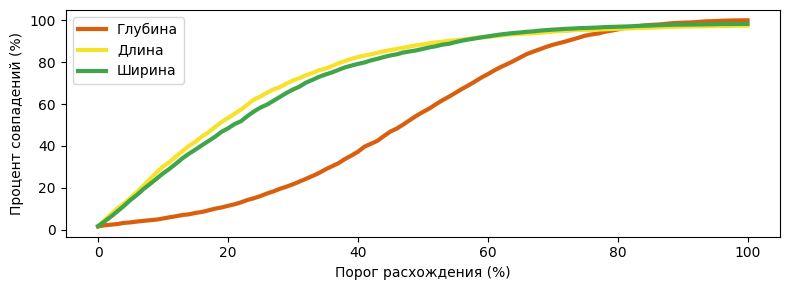

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(thresholds, depth_matching_percent_clean, label='Глубина', color=color_metric[0], linewidth=3)
plt.plot(thresholds, length_matching_percent_clean, label='Длина', color=color_metric[1], linewidth=3)
plt.plot(thresholds, width_matching_percent_clean, label='Ширина', color=color_metric[2], linewidth=3)
# plt.title('Ширина')
plt.xlabel('Порог расхождения (%)')
plt.ylabel('Процент совпадений (%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()

plt.show()

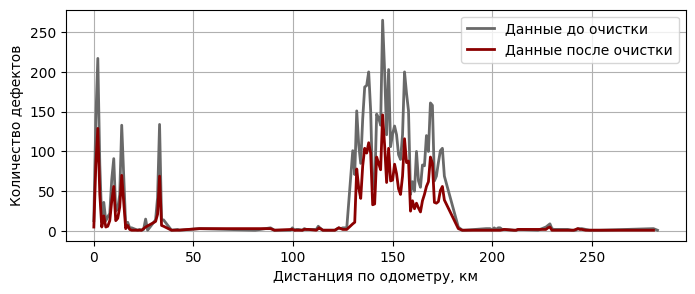

In [ ]:
count_by_distance_after_clean = data_clean.groupby(['ВТД Дистанция по одометру, км']).size()

plt.figure(figsize = (8, 3))
count_by_distance_before_clean.plot(kind='line', stacked=True, color=color_plot[0], label='Данные до очистки', linewidth=2)
count_by_distance_after_clean.plot(kind='line', stacked=True, color=color_plot[1], label='Данные после очистки', linewidth=2)

# plt.title('Сравнение данных до и после очистки')
plt.xlabel('Дистанция по одометру, км')
plt.ylabel('Количество дефектов')
plt.legend()
plt.grid()

plt.show()

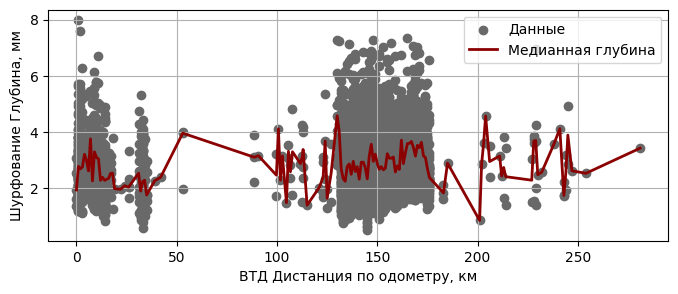

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.scatter(data_clean['ВТД Дистанция по одометру, км'], data_clean['Шурфование Глубина, мм'], color=color_plot[0], label = 'Данные')

average_depth = data_clean.groupby('ВТД Дистанция по одометру, км')['Шурфование Глубина, мм'].median()
sorted_distances = average_depth.index

plt.plot(sorted_distances, average_depth, color=color_plot[1], linewidth=2, label='Медианная глубина')

plt.xlabel('ВТД Дистанция по одометру, км')
plt.ylabel('Шурфование Глубина, мм')
plt.grid()
plt.legend()
plt.show()


In [ ]:
data_clean = data_clean.drop(columns = ['Глубина расхождение', 'Длина расхождение', 'Ширина расхождение',
    'Глубина расхождение, очищенный', 'Длина расхождение, очищенный', 'Ширина расхождение, очищенный'])

KeyError: "['Глубина расхождение', 'Длина расхождение', 'Ширина расхождение'] not found in axis"

# Статистический анализ

In [ ]:
df_other_year_serch = data_clean.copy()

In [ ]:
unique_intervals = df_other_year_serch['Промежуток между исследованиями, лет'].unique()
num_colors = len(unique_intervals)

custom_colors = ['#3F007D', '#2B6C9C', '#3FA44A', '#F7E12B', '#D95F0E', '#8B0000']

# Создаем отображение {значение -> цвет}
color_mapping = {interval: custom_colors[i % len(custom_colors)] for i, interval in enumerate(unique_intervals)}
df_other_year_serch['Цвет'] = df_other_year_serch['Промежуток между исследованиями, лет'].map(color_mapping)

In [ ]:
def clean_outliers(data, threshold=3):
  """измененная z-оценка"""

  data = np.array(data)

  median = np.median(data)
  mad = np.median(np.abs(data - median))

  if mad == 0:
      return np.ones(len(data), dtype=bool)  # Все данные остаются, если MAD = 0

  modified_z_score = (data - median) / mad
  return np.abs(modified_z_score) <= threshold  # Булевский массив: True = оставить, False = удалить

## Глубина

In [ ]:
cols_depth = ['ВТД Глубина, мм',
       'Шурфование Глубина, мм',
       'Промежуток между исследованиями, лет',
       'ВТД Дистанция по одометру, км', 'Цвет']

In [ ]:
df_for_depth = df_other_year_serch[cols_depth]

In [ ]:
# Определяем уникальные значения в столбце
unique_values = df_for_depth['Промежуток между исследованиями, лет'].unique()

# Создаем словарь для хранения отдельных датафреймов
dfs = {}

# Разбиваем датафрейм
for value in unique_values:
    dfs[value] = df_other_year_serch[df_other_year_serch['Промежуток между исследованиями, лет'] == value]

dfs.pop(4)
print(' ')

In [ ]:
for key,value in dfs.items():
  print(value.shape)

(496, 41)
(1875, 41)
(835, 41)
(493, 41)
(20, 41)


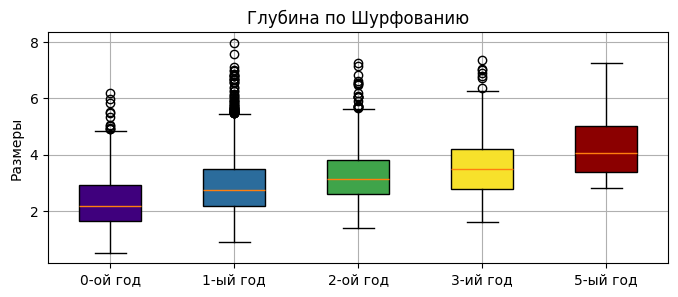

In [ ]:
plt.figure(figsize=(8, 3))

labels = ['0-ой год', '1-ый год', '2-ой год', '3-ий год', '5-ый год']

i = 0
for key, frame in dfs.items():
  plt.boxplot(frame['Шурфование Глубина, мм'], positions=[i], widths=0.5, patch_artist=True, boxprops=dict(facecolor=frame['Цвет'].iloc[0]))
  i += 1

plt.ylabel('Размеры')
plt.title('Глубина по Шурфованию')
plt.xticks([0, 1, 2, 3, 4], labels)
plt.grid()
plt.show()


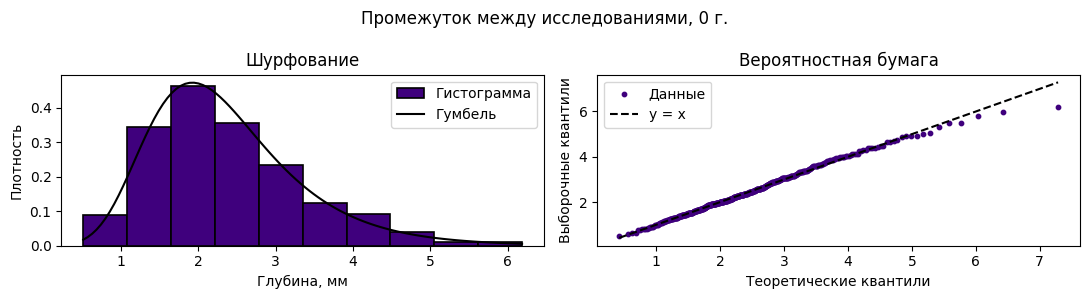

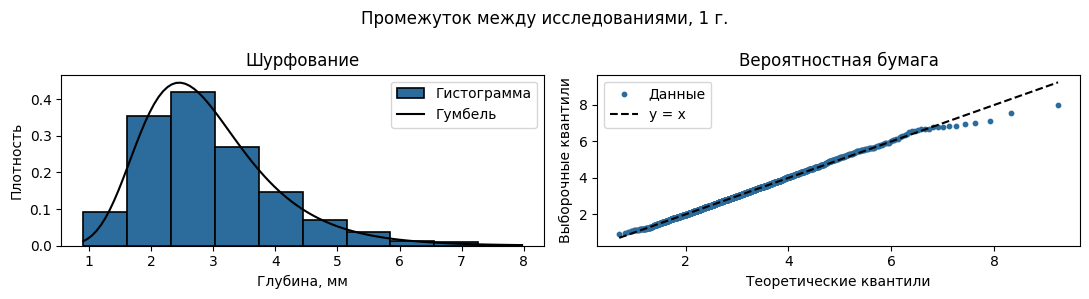

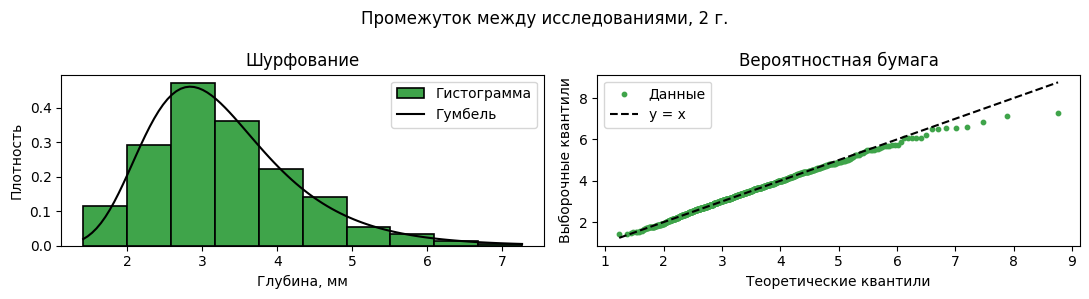

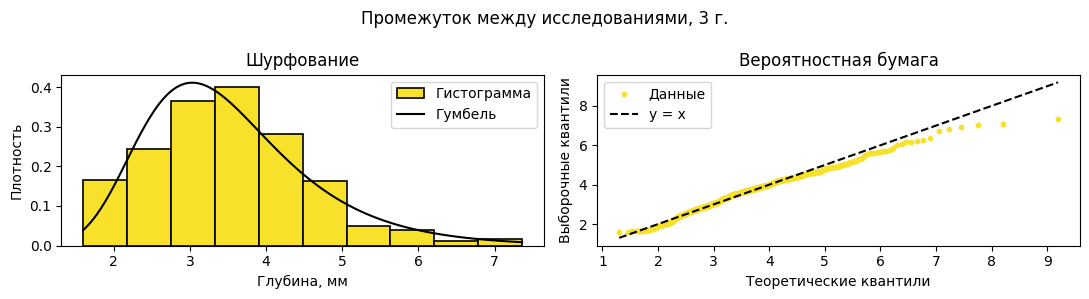

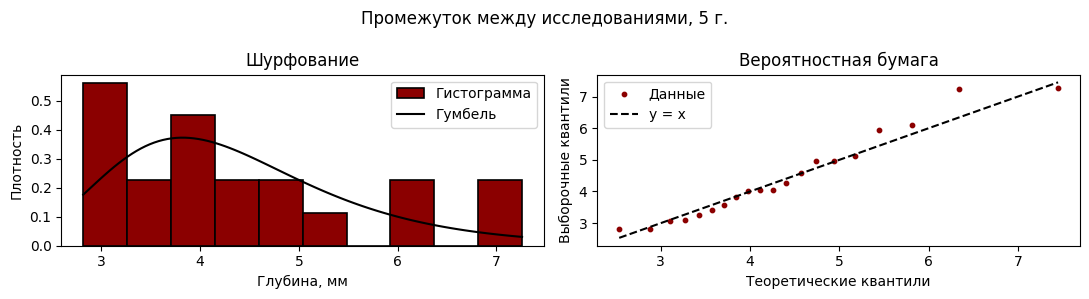

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def estimate_params(data):
    loc, scale = stats.gumbel_r.fit(data)
    return loc, scale

dict_params = {}
i = 0
for key, frame in dfs.items():
    plt.figure(figsize=(11, 3))
    plt.suptitle(f'Промежуток между исследованиями, {key} г.')

    # Гистограмма ВТД Глубина
    # plt.subplot(1, 3, 1)
    # plt.scatter(frame['ВТД Глубина, мм'], frame['Шурфование Глубина, мм'],
    #            color=frame['Цвет'].iloc[0], alpha=0.5, s=50, edgecolor='black')
    # plt.title(f'Совместный график исследований')
    # plt.xlabel('ВТД Глубина, мм')
    # plt.ylabel('Шурфование Глубина, мм')
    # plt.xlim(0, 4)
    # plt.ylim(0, 8)

    # Гистограмма Шурфование Глубина
    plt.subplot(1, 2, 1)
    data_shurf = frame['Шурфование Глубина, мм'].dropna()
    loc_shurf, scale_shurf = estimate_params(data_shurf)
    dict_params[key] = (loc_shurf, scale_shurf)
    x_shurf = np.linspace(data_shurf.min(), data_shurf.max(), 100)
    pdf_shurf = stats.gumbel_r.pdf(x_shurf, loc=loc_shurf, scale=scale_shurf)

    plt.hist(data_shurf, bins=10, density=True, color=frame['Цвет'].iloc[0], label='Гистограмма', edgecolor='black', linewidth=1.2)
    plt.plot(x_shurf, pdf_shurf, color='black', label='Гумбель')
    plt.title(f'Шурфование')
    plt.xlabel('Глубина, мм')
    plt.ylabel('Плотность')
    plt.legend()

    # Вероятностная бумага
    plt.subplot(1, 2, 2)
    sample_quantiles = np.sort(data_shurf)
    n = len(sample_quantiles)
    theoretical_quantiles = stats.gumbel_r.ppf((np.arange(1, n + 1) - 0.5) / n, loc=loc_shurf, scale=scale_shurf)

    plt.scatter(theoretical_quantiles, sample_quantiles, color=frame['Цвет'].iloc[0], label='Данные', s=10)
    plt.plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
             [theoretical_quantiles.min(), theoretical_quantiles.max()],
             color='black', linestyle='--', label='y = x')
    plt.title(f'Вероятностная бумага')
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Выборочные квантили')
    plt.legend()

    plt.tight_layout()
    plt.show()

    i += 1


Взвешенная регрессия: loc = 2.05 + 0.36 * t
Взвешенная регрессия: scale = 0.78 + 0.03 * t


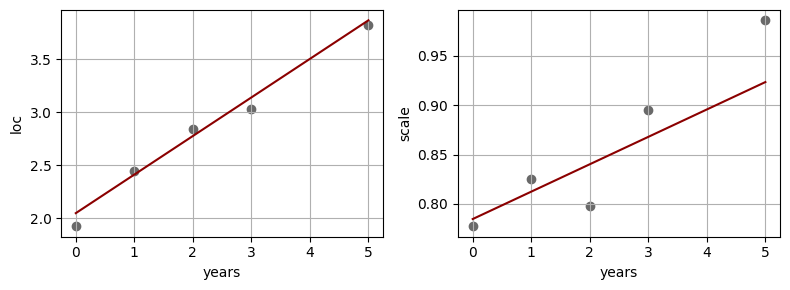

In [ ]:

# Собираем веса для каждого года (количество данных)
weights = []
for key in dict_params.keys():
    frame = dfs[key]
    data_shurf = frame['Шурфование Глубина, мм'].dropna()
    weights.append(len(data_shurf))
weights = np.array(weights)

# Извлечение параметров для регрессии
keys = np.array(list(dict_params.keys()))
values_1 = np.array([value[0] for value in dict_params.values()])
values_2 = np.array([value[1] for value in dict_params.values()])

t = np.array(keys).reshape(-1, 1)
loc = np.array(values_1)
scale = np.array(values_2)

# Функция взвешенной линейной регрессии
def weighted_lin_reg(t, y, w):
    t = t.flatten()
    sum_w = np.sum(w)
    t_mean = np.sum(w * t) / sum_w
    y_mean = np.sum(w * y) / sum_w

    cov = np.sum(w * (t - t_mean) * (y - y_mean))
    var = np.sum(w * (t - t_mean)**2)

    b = cov / var
    a = y_mean - b * t_mean
    return a, b

# Вычисляем коэффициенты с весами
a_loc, b_loc = weighted_lin_reg(t, loc, weights)
a_scale, b_scale = weighted_lin_reg(t, scale, weights)

print(f'Взвешенная регрессия: loc = {a_loc:.2f} + {b_loc:.2f} * t')
print(f'Взвешенная регрессия: scale = {a_scale:.2f} + {b_scale:.2f} * t')

# Визуализация с новыми коэффициентами
plt.figure(figsize=(8, 3))

# plt.subplot(121)
# plt.scatter(t, loc, color=color_plot[0], label='Данные')
# plt.plot(t, a_loc + b_loc * t, color=color_plot[1])
# plt.xlabel('years')
# plt.ylabel('loc')
# # plt.title('Взвешенная регрессия для loc')
# plt.grid()
plt.subplot(121)
plt.scatter(t, loc, color=color_plot[0], label='Данные')
plt.plot(t, a_loc + b_loc * t, color=color_plot[1])
plt.xlabel('years')
plt.ylabel('loc')
# plt.title('Взвешенная регрессия для loc')
plt.grid()

plt.subplot(122)
plt.scatter(t, scale, color=color_plot[0], label='Данные')
plt.plot(t, a_scale + b_scale * t, color=color_plot[1])
plt.xlabel('years')
plt.ylabel('scale')
# plt.title('Взвешенная регрессия для scale')
plt.grid()

plt.tight_layout()
plt.show()

## Длина

In [ ]:
cols_length = ['ВТД Длина, мм', 'Шурфование Длина, мм',
       'Промежуток между исследованиями, лет',
       'ВТД Дистанция по одометру, км', 'Цвет']

In [ ]:
df_for_length = df_other_year_serch[cols_length]

In [ ]:
# Определяем уникальные значения в столбце
unique_values = df_for_length['Промежуток между исследованиями, лет'].unique()

# Создаем словарь для хранения отдельных датафреймов
dfs = {}

# Разбиваем датафрейм
for value in unique_values:
    dfs[value] = df_other_year_serch[df_other_year_serch['Промежуток между исследованиями, лет'] == value]

dfs.pop(4)
print(' ')

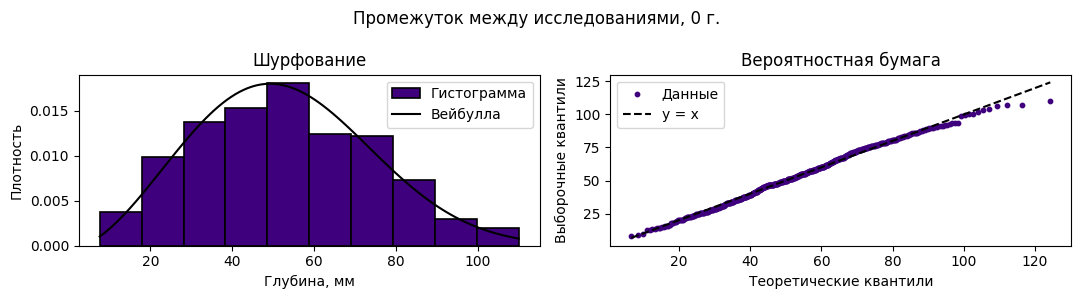

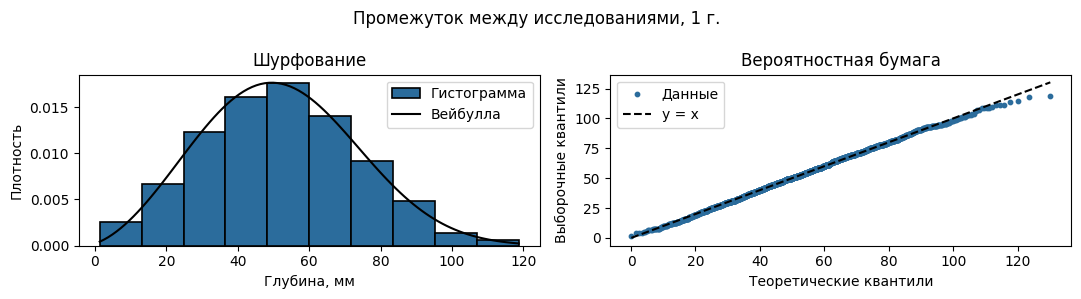

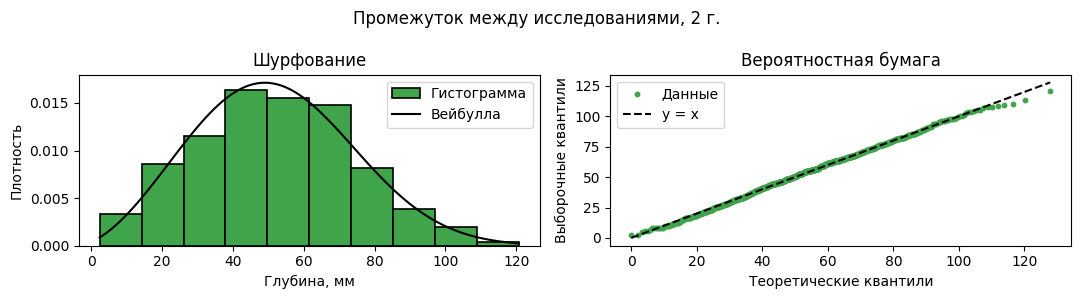

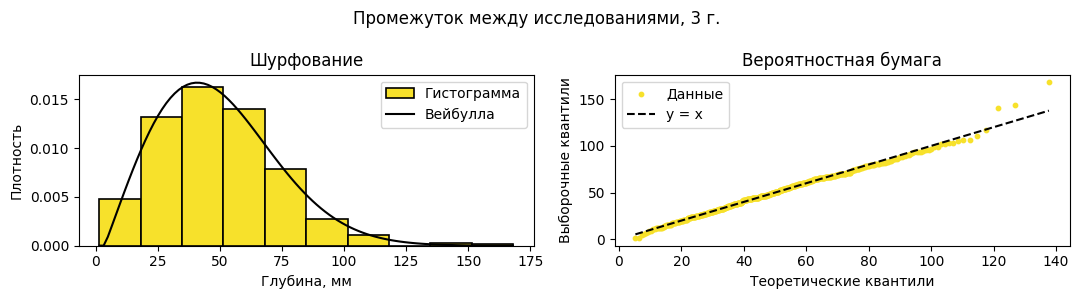

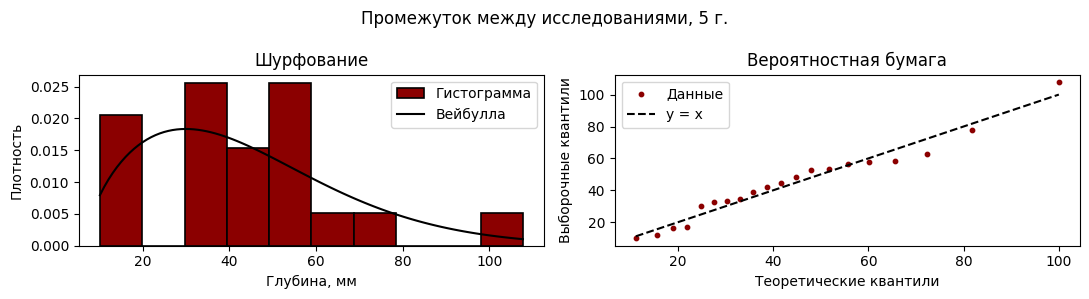

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def estimate_weibull_params(data):
    shape, loc, scale = stats.weibull_min.fit(data)
    return shape, loc, scale

dict_params = {}
i = 0
for key, frame in dfs.items():
    plt.figure(figsize=(11, 3))
    plt.suptitle(f'Промежуток между исследованиями, {key} г.')

    # # Совместный график измерений
    # plt.subplot(1, 3, 1)
    # plt.scatter(frame['ВТД Длина, мм'], frame['Шурфование Длина, мм'],
    #             color=frame['Цвет'].iloc[0], alpha=0.5, s=50, edgecolor='black')
    # plt.title('Совместный график исследований')
    # plt.xlabel('ВТД Длина, мм')
    # plt.ylabel('Шурфование Длина, мм')
    # # plt.xlim(0, 4)
    # # plt.ylim(0, 8)

    # Гистограмма и плотность распределения Вейбулла для "Шурфование Глубина, мм"
    plt.subplot(1, 2, 1)
    data_shurf = frame['Шурфование Длина, мм'].dropna()
    shape, loc, scale = estimate_weibull_params(data_shurf)
    dict_params[key] = (shape, loc, scale)
    x_shurf = np.linspace(data_shurf.min(), data_shurf.max(), 100)
    pdf_shurf = stats.weibull_min.pdf(x_shurf, shape, loc=loc, scale=scale)

    plt.hist(data_shurf, bins=10, density=True, color=frame['Цвет'].iloc[0],
             label='Гистограмма', edgecolor='black', linewidth=1.2)
    plt.plot(x_shurf, pdf_shurf, color='black', label='Вейбулла')
    plt.title('Шурфование')
    plt.xlabel('Глубина, мм')
    plt.ylabel('Плотность')
    plt.legend()

    # Вероятностная бумага (QQ plot)
    plt.subplot(1, 2, 2)
    sample_quantiles = np.sort(data_shurf)
    n = len(sample_quantiles)
    # Вычисление теоретических квантилей для распределения Вейбулла
    theoretical_quantiles = stats.weibull_min.ppf((np.arange(1, n + 1) - 0.5) / n, shape, loc=loc, scale=scale)

    plt.scatter(theoretical_quantiles, sample_quantiles, color=frame['Цвет'].iloc[0],
                label='Данные', s=10)
    plt.plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
             [theoretical_quantiles.min(), theoretical_quantiles.max()],
             color='black', linestyle='--', label='y = x')
    plt.title('Вероятностная бумага')
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Выборочные квантили')
    plt.legend()

    plt.tight_layout()
    plt.show()

    i += 1


Линейная регрессия: shape = 2.8081 + -0.2179 * t
Линейная регрессия: loc   = -1.7000 + 1.3406 * t
Линейная регрессия: scale = 62.8343 + -3.5607 * t


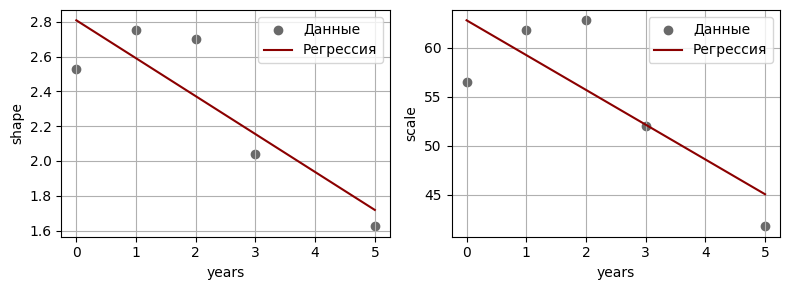

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

keys = np.array(list(dict_params.keys()))
shape_vals = np.array([value[0] for value in dict_params.values()])
loc_vals   = np.array([value[1] for value in dict_params.values()])
scale_vals = np.array([value[2] for value in dict_params.values()])

# Приводим ключи в двумерный массив для линейной регрессии (например, время t)
t = keys.reshape(-1, 1)

def lin_reg(t, y):
    model = LinearRegression()
    model.fit(t, y)
    a = model.intercept_
    b = model.coef_[0]
    return model, (a, b)

# Выполняем линейную регрессию для каждого параметра
model_shape, w_shape = lin_reg(t, shape_vals)
model_loc,   w_loc   = lin_reg(t, loc_vals)
model_scale, w_scale = lin_reg(t, scale_vals)

print(f'Линейная регрессия: shape = {w_shape[0]:.4f} + {w_shape[1]:.4f} * t')
print(f'Линейная регрессия: loc   = {w_loc[0]:.4f} + {w_loc[1]:.4f} * t')
print(f'Линейная регрессия: scale = {w_scale[0]:.4f} + {w_scale[1]:.4f} * t')

# Построение графиков регрессии для каждого параметра
plt.figure(figsize=(8, 3))

# Регрессия для параметра shape
plt.subplot(1, 2, 1)
plt.scatter(t, shape_vals, color=color_plot[0], label='Данные')
plt.plot(t, model_shape.predict(t), color=color_plot[1], label='Регрессия')
plt.xlabel('years')
plt.ylabel('shape')
# plt.title('Зависимость shape от t')
plt.grid()
plt.legend()

# plt.subplot(1, 3, 2)
# plt.scatter(t, loc_vals, color=color_plot[0], label='Данные')
# plt.plot(t, model_shape.predict(t), color=color_plot[1], label='Регрессия')
# plt.xlabel('years')
# plt.ylabel('loc')
# # plt.title('Зависимость shape от t')
# plt.grid()
# plt.legend()

# Регрессия для параметра scale
plt.subplot(1, 2, 2)
plt.scatter(t, scale_vals, color=color_plot[0], label='Данные')
plt.plot(t, model_scale.predict(t), color=color_plot[1], label='Регрессия')
plt.xlabel('years')
plt.ylabel('scale')
# plt.title('Зависимость scale от t')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# Регрессия глубины шурфования

In [ ]:
df_regression = data_clean.copy()

In [ ]:
# Функция для подсчета количества близких записей
def count_close_records(row):
    return df_regression[(df_regression['Участок'] == row['Участок']) &
               (abs(df_regression['ВТД Дистанция по одометру от КЗ, м'] - row['ВТД Дистанция по одометру от КЗ, м']) < 5)].shape[0]

# Применение функции к каждой строке датафрейма
df_regression['Количество дефектов рядом'] = df_regression.apply(count_close_records, axis=1)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer, StandardScaler
from scipy.stats import boxcox

def remove_correlated_features(df, target_str, vif_threshold=5.0):
    """
    Убираем коллинеарные признаки по VIF.
    Пересчитываем VIF заново после каждого удаления.
    """
    df_copy = df.copy()
    X = df_copy.drop(columns=[target_str])

    while True:
        vif_data = pd.DataFrame({
            'feature': X.columns,
            'VIF': [variance_inflation_factor(X.values, i)
                    for i in range(X.shape[1])]
        })
        max_vif = vif_data['VIF'].max()
        if max_vif <= vif_threshold:
            break
        drop_feat = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
        X = X.drop(columns=[drop_feat])

    return pd.concat([X, df_copy[[target_str]]], axis=1)


def transform_features(df, target_str, skew_threshold=0.5, method='yeo-johnson'):
    """
    Авто‑трансформация перекошенных числовых признаков.
    - Для любых данных (включая нули и отрицательные) используем Yeo–Johnson.
    - После трансформации делаем стандартизацию.
    """
    df_copy = df.copy()
    num_cols = df_copy.select_dtypes(include=[np.number]).columns.drop(target_str)

    # Считаем асимметрию только по исходным данным
    skewness = df_copy[num_cols].skew()
    skewed = skewness[skewness.abs() > skew_threshold].index.tolist()

    if skewed:
        # PowerTransformer умеет автоматически выбирать Box‑Cox (для >0) или YJ (для любых).
        pt = PowerTransformer(method=method, standardize=False)
        df_copy[skewed] = pt.fit_transform(df_copy[skewed])

    # И затем возвращаем всё в единую шкалу
    scaler = StandardScaler()
    df_copy[num_cols] = scaler.fit_transform(df_copy[num_cols])

    return df_copy


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def train_RFR(df, target_str):

  # df_processed = remove_correlated_features(df, target_str)
  df_processed = transform_features(df, target_str)

  # Отделяем признаки и целевую переменную
  X = df_processed.drop(columns=[target_str])
  y = df_processed[target_str]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Обучение RandomForestRegressor
  rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=5, random_state=42)
  rf.fit(X_train, y_train)

  return rf, X_test, y_test, metric_model(rf, y_test, X_test)

def train_XGBR(df, target_str):

  df_processed = remove_correlated_features(df, target_str)
  df_processed = transform_features(df, target_str)

  # Отделяем признаки и целевую переменную
  X = df_processed.drop(columns=[target_str])
  y = df_processed[target_str]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Обучение RandomForestRegressor
  xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=5,
    reg_alpha=0.2,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42)

  xgb.fit(X_train, y_train)

  return xgb, X_test, y_test, metric_model(xgb, y_test, X_test)

def metric_model(model, y_test, X_test):
    preds = model.predict(X_test)

    epsilon = 1e-10
    mape = np.mean(np.abs((y_test - preds) / (y_test + epsilon))) * 100

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    results = {
        'importances': model.feature_importances_,
        'r2': r2_score(y_test, preds),
        'rmse': rmse,
        'mape': mape
    }
    return results

def plot_importances(feature_names, importances, name_model):
    plt.figure(figsize=(6, 3))
    sns.barplot(x=importances, y=feature_names, color = '#8B0000')
    plt.title(f'Feature Importance {name_model}')

    plt.show()


In [ ]:
cols = [
       'Протяженность участка, км', 'Количество дефектов рядом',
       'Плотность дефектов на км',
       'Кол-во обнаруженных дефектов Опасных',
       'Кол-во обнаруженных дефектов Стресс-коррозионных',
       '№ дефекта или № дефектной трубы по отчету',
       'ВТД Дистанция по одометру, км',
       'ВТД Глубина, мм', 'ВТД Длина, мм', 'ВТД Ширина, мм',
       'Промежуток между исследованиями, лет'
]

target_depth = 'Шурфование Глубина, мм'
target_length = 'Шурфование Длина, мм'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def plot_tree_based_learning_curve(model_class, X_train, y_train, X_test, y_test,
                                  n_estimators_range, model_params={}):

    train_rmse = []
    test_rmse = []

    for n in n_estimators_range:
        # Инициализация модели с текущим количеством деревьев
        model = model_class(n_estimators=n, **model_params)
        model.fit(X_train, y_train)

        # Прогнозы на тренировочных и тестовых данных
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        # Расчет RMSE
        train_rmse.append(np.sqrt(mean_squared_error(y_train, pred_train)))
        test_rmse.append(np.sqrt(mean_squared_error(y_test, pred_test)))

    # Построение графика
    plt.figure(figsize=(8, 3))
    plt.plot(n_estimators_range, train_rmse, label='Train RMSE', marker='o', color=color_plot[0])
    plt.plot(n_estimators_range, test_rmse, label='Test RMSE', marker='o', color=color_plot[1])
    plt.xlabel('Number of Trees')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve for {model_class.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_and_plot_learning_curve(df, target_str, model_class, model_params, n_estimators_range):
    # Предобработка данных
    df_processed = remove_correlated_features(df, target_str)
    df_processed = transform_features(df_processed, target_str)

    # Подготовка данных
    X = df_processed.drop(columns=[target_str])
    y = df_processed[target_str]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Построение кривой обучения
    plot_tree_based_learning_curve(
        model_class=model_class,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        n_estimators_range=n_estimators_range,
        model_params=model_params
    )

# Для RandomForest
rf_params = {
    'max_depth': 3,
    'min_samples_split': 4,
    'random_state': 42
}

# Для XGBoost
xgb_params = {
    'learning_rate': 0.03,
    'max_depth': 4,
    'reg_alpha': 0.2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'random_state': 42
}

train_and_plot_learning_curve(
    df=df_regression[cols + [target_depth]],
    target_str=target_depth,
    model_class=RandomForestRegressor,
    model_params=rf_params,
    n_estimators_range=range(1, 402, 30)
)

train_and_plot_learning_curve(
    df=df_regression[cols + [target_depth]],
    target_str=target_depth,
    model_class=XGBRegressor,
    model_params=xgb_params,
    n_estimators_range=range(1, 402, 30)
)

train_and_plot_learning_curve(
    df=df_regression[cols + [target_length]],
    target_str=target_length,
    model_class=RandomForestRegressor,
    model_params=rf_params,
    n_estimators_range=range(1, 402, 30)
)

train_and_plot_learning_curve(
    df=df_regression[cols + [target_length]],
    target_str=target_length,
    model_class=XGBRegressor,
    model_params=xgb_params,
    n_estimators_range=range(1, 402, 30)
)

In [ ]:
results = dict()

rf_depth, X_test_rf_depth, Y_test_rf_depth, results['RF_depth'] = train_RFR(df_regression[cols + [target_depth]], target_depth)
xgb_depth, X_test_xgb_depth, Y_test_xgb_depth, results['XGB_depth'] = train_XGBR(df_regression[cols + [target_depth]], target_depth)

rf_length, X_test_rf_length, Y_test_rf_length, results['RF_length'] = train_RFR(df_regression[cols + [target_length]], target_length)
xgb_length, X_test_xgb_length, Y_test_xgb_length, results['XGB_length'] = train_XGBR(df_regression[cols + [target_length]], target_length)


In [ ]:
print(f"""
RandomForest DEPTH Metrics:
R²: {results['RF_depth']['r2']:.3f}
RMSE: {results['RF_depth']['rmse']:.2f}
MAPE: {results['RF_depth']['mape']:.1f}
""")

print(f"""
XGBoost DEPTH Metrics:
R²: {results['XGB_depth']['r2']:.3f}
RMSE: {results['XGB_depth']['rmse']:.2f}
MAPE: {results['XGB_depth']['mape']:.1f}
""")

print(f"""
RandomForest LENGTH Metrics:
R²: {results['RF_length']['r2']:.3f}
RMSE: {results['RF_length']['rmse']:.2f}
MAPE: {results['RF_length']['mape']:.1f}
""")

print(f"""
XGBoost LENGTH Metrics:
R²: {results['XGB_length']['r2']:.3f}
RMSE: {results['XGB_length']['rmse']:.2f}
MAPE: {results['XGB_length']['mape']:.1f}
""")

In [ ]:
X_test_xgb_depth.describe()

In [ ]:
plot_importances(X_test_rf_depth.columns, results['RF_depth']['importances'], 'RandomForest Depth')
plot_importances(X_test_xgb_depth.columns, results['XGB_depth']['importances'], 'XGBoost Depth')
plot_importances(X_test_rf_length.columns, results['RF_length']['importances'], 'RandomForest Length')
plot_importances(X_test_xgb_length.columns, results['XGB_length']['importances'], 'XGBoost Length')

In [ ]:
import pandas as pd

# Получаем названия признаков для каждой целевой переменной
feature_names_depth = X_test_rf_depth.columns.tolist()
feature_names_length = X_test_rf_length.columns.tolist()

# Собираем все уникальные признаки
all_features = list(set(feature_names_depth + feature_names_length))

# Создаем DataFrame с важностью признаков для каждой модели
importance_data = {
    'Признак': all_features,
    'RF_depth': [results['RF_depth']['importances'][feature_names_depth.index(f)] if f in feature_names_depth else 0 for f in all_features],
    'XGB_depth': [results['XGB_depth']['importances'][feature_names_depth.index(f)] if f in feature_names_depth else 0 for f in all_features],
    'RF_length': [results['RF_length']['importances'][feature_names_length.index(f)] if f in feature_names_length else 0 for f in all_features],
    'XGB_length': [results['XGB_length']['importances'][feature_names_length.index(f)] if f in feature_names_length else 0 for f in all_features]
}

# Создаем DataFrame и сортируем по сумме важностей
importance_df = pd.DataFrame(importance_data)
importance_df['Суммарная важность'] = importance_df[['RF_depth', 'XGB_depth', 'RF_length', 'XGB_length']].sum(axis=1)
importance_df = importance_df.sort_values(by='Суммарная важность', ascending=False).reset_index(drop=True)

# Убираем столбец с суммарной важностью (опционально)
importance_df.drop(columns=['Суммарная важность'], inplace=True)

# Округляем значения для читаемости
importance_df = importance_df.round(3)

# Выводим таблицу
display(importance_df)

In [ ]:
depth_xgb_df = pd.DataFrame({'Y_true':Y_test_xgb_depth, 'Y_pred':xgb_depth.predict(X_test_xgb_depth), 'Depth_vtd':X_test_xgb_depth['ВТД Глубина, мм']})
depth_xgb_df = depth_xgb_df.sort_values('Y_true')

length_xgb_df = pd.DataFrame({'Y_true':Y_test_xgb_length, 'Y_pred':xgb_length.predict(X_test_xgb_length), 'Length_vtd':X_test_xgb_depth['ВТД Длина, мм']})
length_xgb_df = length_xgb_df.sort_values('Y_true')

plt.figure(figsize = (8, 3))
plt.subplot(121)
plt.plot(depth_xgb_df['Y_true'], depth_xgb_df['Y_pred'], color = color_plot[1], linewidth=2)
plt.xlabel('Истинная глубина')
plt.ylabel('Предсказанная глубина')
plt.title('XGBoost')
plt.xlim(1.5, 7)
plt.ylim(1.5, 7)

plt.subplot(122)
plt.plot(length_xgb_df['Y_true'], length_xgb_df['Y_pred'], color = color_plot[1], linewidth=2)
plt.xlabel('Истинная длина')
plt.ylabel('Предсказанная длина')
plt.title('XGBoost')
plt.xlim(0, 130)
plt.ylim(0, 130)

In [ ]:
depth_xgb_df = depth_xgb_df.sort_values('Depth_vtd')
length_xgb_df = length_xgb_df.sort_values('Length_vtd')

plt.figure(figsize = (8, 3))
plt.subplot(121)
plt.scatter(depth_xgb_df['Depth_vtd'], depth_xgb_df['Y_pred'] - depth_xgb_df['Y_true'], color = color_plot[1], linewidth=2)
plt.xlabel('Глубина по ВТД (нормированная)')
plt.ylabel('Остатки')
plt.title('XGBoost')
# plt.xlim(1.5, 7)
# plt.ylim(1.5, 7)

plt.subplot(122)
plt.scatter(length_xgb_df['Length_vtd'], length_xgb_df['Y_pred'] - length_xgb_df['Y_true'], color = color_plot[1], linewidth=2)
plt.xlabel('Длина по ВТД (нормированная)')
plt.ylabel('Остатки')
plt.title('XGBoost')
# plt.xlim(0, 130)
# plt.ylim(0, 130)

### Адекватность модели

In [ ]:
from scipy.stats import f
from scipy.stats import norm
from scipy.stats import chi2
from scipy import stats

# Функция проверки гипотезы о постоянстве мат. ожидания
def check_constant_mean(X, residuals, variable, k=10, alpha=0.05):
    n = len(residuals)
    m = X.shape[1]

    # Упорядочивание по переменной
    sorted_idx = np.argsort(variable)
    sorted_residuals = residuals[sorted_idx]

    # Разбиение на группы
    groups = np.array_split(sorted_residuals, k)
    group_means = [np.mean(g) for g in groups]
    overall_mean = np.mean(sorted_residuals)

    # Расчет S0^2 и S^2
    S0_sq = sum(len(g)*(gm - overall_mean)**2 for g, gm in zip(groups, group_means))
    S_sq = sum(np.sum((g - gm)**2) for g, gm in zip(groups, group_means))

    # F-статистика
    df_num = k - m
    df_den = n - k

    if df_num <= 0 or df_den <= 0:
        return None, None

    F_stat = (S0_sq/df_num) / (S_sq/df_den)
    # crit = f.ppf(1-alpha, df_num, df_den)
    p_value = 1 - f.cdf(F_stat, df_num, df_den)
    return F_stat, p_value


In [ ]:
def call_check_constant_mean(model, X, Y, name='ВТД Глубина, мм', alpha=0.05):
  y_pred = model.predict(X)
  residuals = Y - y_pred

  X = X.reset_index(drop=True)
  Y = Y.reset_index(drop=True)
  residuals = pd.Series(residuals).reset_index(drop=True)
  var = X[name]

  print("\nПроверка гипотез:")
  F, p_value = check_constant_mean(X, residuals, var, 12)
  if F is None:
      print(f"Недостаточно данных для проверки")

  plt.figure()
  plt.scatter(np.sort(var), residuals[np.argsort(var)], color = color_plot[1])
  plt.ylabel("Остатки")
  plt.grid(True)
  plt.show()

  print(f"F-статистика: {F:.2f}")
  print(f"p_value: {p_value:.4f}")
  print("Гипотеза отвергается" if alpha > p_value else "Гипотеза не отвергается")


call_check_constant_mean(xgb_depth, X_test_xgb_depth, Y_test_xgb_depth, name='ВТД Глубина, мм')
call_check_constant_mean(xgb_length, X_test_xgb_length, Y_test_xgb_length, name='ВТД Глубина, мм')


In [ ]:
def goldfeld_quandt_test(X, y, variable, alpha=0.05, n1=None, n2=None):
    sorted_indices = np.argsort(variable.values)
    X_sorted = X.iloc[sorted_indices].values
    y_sorted = y.iloc[sorted_indices].values

    n = len(y)
    if n1 is None or n2 is None:
        n1 = n2 = n // 4

    X1 = X_sorted[:n1]
    y1 = y_sorted[:n1]
    X2 = X_sorted[-n2:]
    y2 = y_sorted[-n2:]

    beta1 = np.linalg.pinv(X1.T @ X1) @ X1.T @ y1
    residuals1 = y1 - X1 @ beta1
    S1_sq = np.sum(residuals1**2)

    beta2 = np.linalg.pinv(X2.T @ X2) @ X2.T @ y2
    residuals2 = y2 - X2 @ beta2
    S2_sq = np.sum(residuals2**2)

    m = X.shape[1]
    df1 = n1 - m
    df2 = n2 - m

    # Убедимся, что большая сумма в числителе
    if S1_sq > S2_sq:
        F_stat = (S1_sq / df1) / (S2_sq / df2)
        p_value = 1 - f.cdf(F_stat, df1, df2)
    else:
        F_stat = (S2_sq / df2) / (S1_sq / df1)
        p_value = 1 - f.cdf(F_stat, df2, df1)

    return F_stat, p_value

In [ ]:
def call_goldfeld_quandt_test(X, Y, name='ВТД Глубина, мм', alpha=0.05):

  X = X.reset_index(drop=True)
  Y = Y.reset_index(drop=True)
  var = X[name]

  print("Результаты проверки критерия Голдфелда-Куандта:")

  F, p_value = goldfeld_quandt_test(X, Y, var)
  print(f"F-статистика: {F:.3f}")
  print(f"p_value: {p_value:.3f}")
  if alpha > p_value:
      print("Гипотеза отвергается")
  else:
      print("Гипотеза не отвергается")

call_goldfeld_quandt_test(X_test_xgb_depth, Y_test_xgb_depth, name='ВТД Длина, мм')
call_goldfeld_quandt_test(X_test_xgb_length, Y_test_xgb_length, name='ВТД Длина, мм')

In [ ]:
def check_autocorrelation(residuals, max_lag=50, alpha=0.05):

    m = 7
    n = len(residuals)
    sigma2 = np.var(residuals, ddof=1)

    # Вычисление автокорреляций
    acf = []
    for k in range(max_lag + 1):
        # Закольцовывание индексов
        sum_product = 0.0
        for i in range(n):
            idx = (i - k) % n  # Обработка отрицательных индексов
            sum_product += residuals[i] * residuals[idx]
        gamma_k = sum_product / n
        rho_k = gamma_k / sigma2
        acf.append(rho_k)

    z_critical = norm.ppf(1 - alpha/2)
    conf_interval = z_critical / np.sqrt(n)

    # График
    plt.figure(figsize=(12, 6))

    # Стем-график с настройками
    markerline, stemlines, baseline = plt.stem(
        range(max_lag + 1),
        acf,
        linefmt='-',  # Стиль линии (без цвета)
        markerfmt='o',  # Стиль маркера (без цвета)
        basefmt=' ',
    )

    # Установка цвета и толщины для стеблей и маркеров
    plt.setp(stemlines, color=color_plot[1], linewidth=2, alpha=1)
    plt.setp(markerline, color=color_plot[1], markersize=6)

    # Пунктирные границы доверительного интервала
    plt.axhline(y=conf_interval, color=color_plot[0],
                linestyle='--', linewidth=1.5,
                label='Доверительный интервал')
    plt.axhline(y=-conf_interval, color=color_plot[0],
                linestyle='--', linewidth=1.5)

    # Оформление
    plt.xlabel('Лаг', fontsize=12)
    plt.ylabel('Автокорреляция', fontsize=12)
    plt.title('Выборочная автокорреляционная функция (ACF)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Проверка значимости
    significant_lags = [k for k, rho in enumerate(acf)
                       if abs(rho) > conf_interval and k != 0]

    print(f"Критическое значение:{conf_interval:.3f}")
    if significant_lags:
        print(f"Обнаружена автокорреляция на лагах: {significant_lags}")
    else:
        print("Автокорреляция не обнаружена")

    # Q-критерий Льюнга-Вокса
    Q = n * (n + 2) * sum((rho**2)/(n - k) for k, rho in enumerate(acf[1:max_lag+1], 1))
    df = max_lag - m
    critical_value = chi2.ppf(1 - alpha, df)
    p_value = 1 - chi2.cdf(Q, df)

    print(f"\nQ-статистика Льюнга-Вокса: {Q:.2f}")
    print(f"Критическое значение хи^2({df}) при alpha={alpha}: {critical_value:.2f}")
    print(f"p-value: {p_value:.4f}")

    if Q > critical_value:
        print("\nГипотеза отвергается")
    else:
        print("\nГипотеза не отвергается")

In [ ]:
def call_check_autocorrelation(model, X, Y):
  y_pred = model.predict(X)
  residuals = Y - y_pred

  X = X.reset_index(drop=True)
  Y = Y.reset_index(drop=True)
  residuals = pd.Series(residuals).reset_index(drop=True)

  check_autocorrelation(residuals)

call_check_autocorrelation(xgb_depth, X_test_xgb_depth, Y_test_xgb_depth)
call_check_autocorrelation(xgb_length, X_test_xgb_length, Y_test_xgb_length)

In [ ]:
def check_normality(X, residuals, alpha=0.05, k_bins=None):
    n = len(residuals)
    m = X.shape[1]

    # Нормирование остатков
    sigma_hat = np.sqrt(np.sum(residuals**2) / (n - m))
    normalized_residuals = residuals / sigma_hat

    # Гистограмма с нормальной кривой
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(normalized_residuals, bins=k_bins or 'auto', density=True, alpha=0.6, color='skyblue')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, 0, 1)
    plt.plot(x, p, 'r', linewidth=2)
    plt.title('Гистограмма остатков')
    plt.xlabel('Нормированные остатки')
    plt.ylabel('Плотность')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(normalized_residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot')
    plt.tight_layout()
    plt.show()

    # Критерий Пирсона-Фишера
    # if k_bins is None:
    #     k_bins = int(1 + 3.322 * np.log10(n))  # Правило Стёрджеса
    k_bins = 14

    sorted_res = np.sort(normalized_residuals)
    bins = np.linspace(sorted_res[0], sorted_res[-1], k_bins + 1)

    # Наблюдаемые частоты
    observed, _ = np.histogram(normalized_residuals, bins=bins)


    # Теоретические вероятности
    cdf = norm.cdf(bins)
    expected_prob = np.diff(cdf)
    expected = expected_prob * n

    # Удаление интервалов с нулевыми ожиданиями
    valid = expected > 0
    observed = observed[valid]
    expected = expected[valid]

    # Статистика хи-квадрат
    chi2_stat = np.sum((observed - expected)**2 / expected)
    dof = len(observed) - m - 2
    critical_value = chi2.ppf(1 - alpha, dof)

    print(f"Статистика хи^2: {chi2_stat:.3f}")
    print(f"Критическое значение (alpha={alpha}): {critical_value:.3f}")
    print(f"Степени свободы: {dof}")
    if chi2_stat > critical_value:
        print("Гипотеза отвергается")
    else:
        print("Гипотеза не отвергается")

In [ ]:
def call_check_normality(model, X, Y):
  y_pred = model.predict(X)
  residuals = Y - y_pred

  X = X.reset_index(drop=True)
  Y = Y.reset_index(drop=True)
  residuals = pd.Series(residuals).reset_index(drop=True)

  check_normality(X, residuals)

call_check_normality(xgb_depth, X_test_xgb_depth, Y_test_xgb_depth)
call_check_normality(xgb_length, X_test_xgb_length, Y_test_xgb_length)
